<a href="https://colab.research.google.com/github/StevenBryceLee/DS-Unit-2-Linear-Models/blob/master/module4-logistic-regression/Copy_of_LS_DS_214_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [ ] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [ ] Begin with baselines for classification.
- [ ] Use scikit-learn for logistic regression.
- [ ] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [ ] Get your model's test accuracy. (One time, at the end.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

- [ ] Add your own stretch goal(s) !
- [ ] Make exploratory visualizations.
- [ ] Do one-hot encoding.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Get and plot your coefficients.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [284]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [285]:
# Load data downloaded from https://srcole.github.io/100burritos/
import pandas as pd
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv')

In [286]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

In [287]:
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

In [288]:
# Drop some high cardinality categoricals
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])

In [289]:
# Drop some columns to prevent "leakage"
df = df.drop(columns=['Rec', 'overall'])

###Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.

In [290]:
#Can't use train test split from sklearn because the split is non-random
df.head()

,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,1/18/2016,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,California,1/24/2016,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,Carnitas,1/24/2016,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,Asada,1/24/2016,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,California,1/27/2016,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


###We need to clean the data before splitting

In [291]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421 entries, 0 to 422
Data columns (total 59 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Burrito         421 non-null    object 
 1   Date            421 non-null    object 
 2   Yelp            87 non-null     float64
 3   Google          87 non-null     float64
 4   Chips           26 non-null     object 
 5   Cost            414 non-null    float64
 6   Hunger          418 non-null    float64
 7   Mass (g)        22 non-null     float64
 8   Density (g/mL)  22 non-null     float64
 9   Length          283 non-null    float64
 10  Circum          281 non-null    float64
 11  Volume          281 non-null    float64
 12  Tortilla        421 non-null    float64
 13  Temp            401 non-null    float64
 14  Meat            407 non-null    float64
 15  Fillings        418 non-null    float64
 16  Meat:filling    412 non-null    float64
 17  Uniformity      419 non-null    flo

In [292]:
#Need this for the stretch goals
final_df = df.copy()

In [293]:
#Just going to drop columns which are mostly null
clean = df.dropna(axis = 1,thresh = int(len(df) * (2/3)))
clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421 entries, 0 to 422
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Burrito       421 non-null    object 
 1   Date          421 non-null    object 
 2   Cost          414 non-null    float64
 3   Hunger        418 non-null    float64
 4   Length        283 non-null    float64
 5   Circum        281 non-null    float64
 6   Volume        281 non-null    float64
 7   Tortilla      421 non-null    float64
 8   Temp          401 non-null    float64
 9   Meat          407 non-null    float64
 10  Fillings      418 non-null    float64
 11  Meat:filling  412 non-null    float64
 12  Uniformity    419 non-null    float64
 13  Salsa         396 non-null    float64
 14  Synergy       419 non-null    float64
 15  Wrap          418 non-null    float64
 16  Great         421 non-null    bool   
dtypes: bool(1), float64(14), object(2)
memory usage: 56.3+ KB


In [294]:
clean.tail()

,Burrito,Date,Cost,Hunger,Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Great
418,Other,8/27/2019,6.0,1.0,17.0,20.5,0.57,5.0,4.0,3.5,NaN,4.0,4.0,2.0,2.0,5.0,False
419,Other,8/27/2019,6.0,4.0,19.0,26.0,1.02,4.0,5.0,NaN,3.5,4.0,4.0,5.0,4.0,3.0,True
420,California,8/27/2019,7.9,3.0,20.0,22.0,0.77,4.0,4.0,4.0,3.7,3.0,2.0,3.5,4.0,4.5,False
421,Other,8/27/2019,7.9,3.0,22.5,24.5,1.07,5.0,2.0,5.0,5.0,5.0,2.0,5.0,5.0,2.0,True
422,Other,8/27/2019,5.5,3.5,17.0,21.3,0.61,3.0,5.0,4.3,4.0,4.9,3.8,3.0,4.5,4.0,True


In [295]:
#Much better...Now working on interpolating
#All NaN columns are numbers, so we can interpolate then fill the rest with mean
import numpy as np
clean = clean.interpolate()
clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421 entries, 0 to 422
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Burrito       421 non-null    object 
 1   Date          421 non-null    object 
 2   Cost          421 non-null    float64
 3   Hunger        421 non-null    float64
 4   Length        348 non-null    float64
 5   Circum        348 non-null    float64
 6   Volume        348 non-null    float64
 7   Tortilla      421 non-null    float64
 8   Temp          421 non-null    float64
 9   Meat          421 non-null    float64
 10  Fillings      421 non-null    float64
 11  Meat:filling  421 non-null    float64
 12  Uniformity    421 non-null    float64
 13  Salsa         421 non-null    float64
 14  Synergy       421 non-null    float64
 15  Wrap          421 non-null    float64
 16  Great         421 non-null    bool   
dtypes: bool(1), float64(14), object(2)
memory usage: 56.3+ KB


In [296]:
#Only 3 columns left
nancols = ['Length','Circum','Volume']
for col in nancols:
  clean[col] = clean[col].fillna(clean[col].mean())
clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421 entries, 0 to 422
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Burrito       421 non-null    object 
 1   Date          421 non-null    object 
 2   Cost          421 non-null    float64
 3   Hunger        421 non-null    float64
 4   Length        421 non-null    float64
 5   Circum        421 non-null    float64
 6   Volume        421 non-null    float64
 7   Tortilla      421 non-null    float64
 8   Temp          421 non-null    float64
 9   Meat          421 non-null    float64
 10  Fillings      421 non-null    float64
 11  Meat:filling  421 non-null    float64
 12  Uniformity    421 non-null    float64
 13  Salsa         421 non-null    float64
 14  Synergy       421 non-null    float64
 15  Wrap          421 non-null    float64
 16  Great         421 non-null    bool   
dtypes: bool(1), float64(14), object(2)
memory usage: 56.3+ KB


In [297]:
clean.head()

,Burrito,Date,Cost,Hunger,Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Great
0,California,1/18/2016,6.49,3.0,19.933822,22.194468,0.786379,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,False
1,California,1/24/2016,5.45,3.5,19.933822,22.194468,0.786379,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,False
2,Carnitas,1/24/2016,4.85,1.5,19.933822,22.194468,0.786379,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,False
3,Asada,1/24/2016,5.25,2.0,19.933822,22.194468,0.786379,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,False
4,California,1/27/2016,6.59,4.0,19.933822,22.194468,0.786379,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,True


In [298]:
#Transforming burrito into categorical
from category_encoders import OneHotEncoder
ohe = OneHotEncoder(use_cat_names=True,cols = 'Burrito')
clean_T = ohe.fit_transform(clean)
clean_T.head(2)

,Burrito_California,Burrito_Carnitas,Burrito_Asada,Burrito_Other,Burrito_Surf & Turf,Date,Cost,Hunger,Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Great
0,1,0,0,0,0,1/18/2016,6.49,3.0,19.933822,22.194468,0.786379,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,False
1,1,0,0,0,0,1/24/2016,5.45,3.5,19.933822,22.194468,0.786379,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,False


In [299]:
#So I don't have to figure out where I changed my code
df = clean_T

In [300]:
clean_T.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421 entries, 0 to 422
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Burrito_California   421 non-null    int64  
 1   Burrito_Carnitas     421 non-null    int64  
 2   Burrito_Asada        421 non-null    int64  
 3   Burrito_Other        421 non-null    int64  
 4   Burrito_Surf & Turf  421 non-null    int64  
 5   Date                 421 non-null    object 
 6   Cost                 421 non-null    float64
 7   Hunger               421 non-null    float64
 8   Length               421 non-null    float64
 9   Circum               421 non-null    float64
 10  Volume               421 non-null    float64
 11  Tortilla             421 non-null    float64
 12  Temp                 421 non-null    float64
 13  Meat                 421 non-null    float64
 14  Fillings             421 non-null    float64
 15  Meat:filling         421 non-null    flo

In [301]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421 entries, 0 to 422
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Burrito_California   421 non-null    int64  
 1   Burrito_Carnitas     421 non-null    int64  
 2   Burrito_Asada        421 non-null    int64  
 3   Burrito_Other        421 non-null    int64  
 4   Burrito_Surf & Turf  421 non-null    int64  
 5   Date                 421 non-null    object 
 6   Cost                 421 non-null    float64
 7   Hunger               421 non-null    float64
 8   Length               421 non-null    float64
 9   Circum               421 non-null    float64
 10  Volume               421 non-null    float64
 11  Tortilla             421 non-null    float64
 12  Temp                 421 non-null    float64
 13  Meat                 421 non-null    float64
 14  Fillings             421 non-null    float64
 15  Meat:filling         421 non-null    flo

###Back to splitting

In [302]:
#Date is a string, so we can split it and get the year
train = df[df['Date'].apply(lambda x: int(x.split('/')[-1])) == 2016]
val = df[df['Date'].apply(lambda x: int(x.split('/')[-1])) == 2017]
test = df[df['Date'].apply(lambda x: int(x.split('/')[-1])) >= 2018]

In [303]:
df

,Burrito_California,Burrito_Carnitas,Burrito_Asada,Burrito_Other,Burrito_Surf & Turf,Date,Cost,Hunger,Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Great
0,1,0,0,0,0,1/18/2016,6.49,3.0,19.933822,22.194468,0.786379,3.0,5.0,3.00,3.5,4.0,4.0,4.0,4.0,4.0,False
1,1,0,0,0,0,1/24/2016,5.45,3.5,19.933822,22.194468,0.786379,2.0,3.5,2.50,2.5,2.0,4.0,3.5,2.5,5.0,False
2,0,1,0,0,0,1/24/2016,4.85,1.5,19.933822,22.194468,0.786379,3.0,2.0,2.50,3.0,4.5,4.0,3.0,3.0,5.0,False
3,0,0,1,0,0,1/24/2016,5.25,2.0,19.933822,22.194468,0.786379,3.0,2.0,3.50,3.0,4.0,5.0,4.0,4.0,5.0,False
4,1,0,0,0,0,1/27/2016,6.59,4.0,19.933822,22.194468,0.786379,4.0,5.0,4.00,3.5,4.5,5.0,2.5,4.5,4.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418,0,0,0,1,0,8/27/2019,6.00,1.0,17.000000,20.500000,0.570000,5.0,4.0,3.50,4.0,4.0,4.0,2.0,2.0,5.0,False
419,0,0,0,1,0,8/27/2019,6.00,4.0,19.000000,26.000000,1.020000,4.0,5.0,3.75,3.5,4.0,4.0,5.0,4.0,3.0,True
420,1,0,0,0,0,8/27/2019,7.90,3.0,20.000000,22.000000,0.770000,4.0,4.0,4.00,3.7,3.0,2.0,3.5,4.0,4.5,False
421,0,0,0,1,0,8/27/2019,7.90,3.0,22.500000,24.500000,1.070000,5.0,2.0,5.00,5.0,5.0,2.0,5.0,5.0,2.0,True


In [304]:
train.head()

,Burrito_California,Burrito_Carnitas,Burrito_Asada,Burrito_Other,Burrito_Surf & Turf,Date,Cost,Hunger,Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Great
0,1,0,0,0,0,1/18/2016,6.49,3.0,19.933822,22.194468,0.786379,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,False
1,1,0,0,0,0,1/24/2016,5.45,3.5,19.933822,22.194468,0.786379,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,False
2,0,1,0,0,0,1/24/2016,4.85,1.5,19.933822,22.194468,0.786379,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,False
3,0,0,1,0,0,1/24/2016,5.25,2.0,19.933822,22.194468,0.786379,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,False
4,1,0,0,0,0,1/27/2016,6.59,4.0,19.933822,22.194468,0.786379,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,True


In [305]:
val.head()

,Burrito_California,Burrito_Carnitas,Burrito_Asada,Burrito_Other,Burrito_Surf & Turf,Date,Cost,Hunger,Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Great
301,1,0,0,0,0,1/4/2017,6.60,3.766667,23.0,20.5,0.77,4.0,4.5,4.00,3.5,3.5,5.0,1.5,3.50,4.5,False
302,0,0,0,1,0,1/4/2017,6.60,3.833333,20.5,21.5,0.75,4.0,2.0,4.05,4.0,3.6,4.6,4.2,3.75,5.0,False
303,0,0,0,1,0,1/7/2017,8.50,3.900000,21.0,21.0,0.74,3.0,4.5,4.10,3.0,3.7,4.0,4.3,4.20,5.0,False
304,0,0,0,1,0,1/7/2017,7.90,4.000000,20.5,21.0,0.72,3.5,4.0,4.00,3.0,4.0,4.5,4.0,3.80,4.8,False
305,0,0,0,1,0,1/10/2017,4.99,3.500000,18.5,22.5,0.75,2.5,4.5,3.00,2.5,3.0,3.0,2.0,2.00,4.0,False


In [306]:
test.head()

,Burrito_California,Burrito_Carnitas,Burrito_Asada,Burrito_Other,Burrito_Surf & Turf,Date,Cost,Hunger,Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Great
77,1,0,0,0,0,4/25/2026,8.00,4.0,21.59,22.5,0.870,4.5,5.0,5.0,5.0,4.5,5.0,3.0,5.0,5.0,True
386,1,0,0,0,0,1/2/2018,7.25,4.0,20.25,22.0,0.785,4.0,5.0,4.0,5.0,5.0,3.0,3.0,4.0,5.0,False
387,0,0,0,1,0,1/9/2018,4.19,3.0,20.50,22.5,0.830,3.0,5.0,2.0,2.0,4.0,1.0,4.0,3.0,4.0,False
388,1,0,0,0,0,1/12/2018,7.00,5.0,20.75,23.0,0.875,5.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,5.0,True
389,0,0,0,1,0,1/12/2018,8.50,4.0,21.00,23.5,0.920,4.0,4.0,3.0,3.5,1.0,2.0,3.0,3.0,1.0,False


Tons of NaNs. I'm sure that's fine and I won't need to deal with that.

Update: That wasn't fine and I needed to deal with that.

In [307]:
#I need to convert Date to a number. Reusing old code
from datetime import datetime
def datetoInt(dateSeries):
  '''
  This function takes a series of strings of type date, and returns a series
  that is a count from the minimum value to the value of the date

  dateSeries is a series of strings signifying a date

  returns a series of the same length of dateSeries
  '''
  return (pd.to_datetime(dateSeries).dt.date - pd.to_datetime(dateSeries).dt.date.min()).apply(lambda x: x.days)



In [308]:
#Apply the transformation
dfList = [train,val,test]
for df in dfList:
  
  df['Days'] = datetoInt(df['Date'])
  #df.drop('Date',axis = 1, inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [309]:
train.head()

,Burrito_California,Burrito_Carnitas,Burrito_Asada,Burrito_Other,Burrito_Surf & Turf,Date,Cost,Hunger,Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Great,Days
0,1,0,0,0,0,1/18/2016,6.49,3.0,19.933822,22.194468,0.786379,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,False,0
1,1,0,0,0,0,1/24/2016,5.45,3.5,19.933822,22.194468,0.786379,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,False,6
2,0,1,0,0,0,1/24/2016,4.85,1.5,19.933822,22.194468,0.786379,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,False,6
3,0,0,1,0,0,1/24/2016,5.25,2.0,19.933822,22.194468,0.786379,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,False,6
4,1,0,0,0,0,1/27/2016,6.59,4.0,19.933822,22.194468,0.786379,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,True,9


In [310]:
#Now we need to drop the date column 
for df in dfList:
  
  df.drop('Date',axis = 1, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [311]:
train.head()

,Burrito_California,Burrito_Carnitas,Burrito_Asada,Burrito_Other,Burrito_Surf & Turf,Cost,Hunger,Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Great,Days
0,1,0,0,0,0,6.49,3.0,19.933822,22.194468,0.786379,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,False,0
1,1,0,0,0,0,5.45,3.5,19.933822,22.194468,0.786379,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,False,6
2,0,1,0,0,0,4.85,1.5,19.933822,22.194468,0.786379,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,False,6
3,0,0,1,0,0,5.25,2.0,19.933822,22.194468,0.786379,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,False,6
4,1,0,0,0,0,6.59,4.0,19.933822,22.194468,0.786379,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,True,9


###Begin with baselines for classification.

In [312]:
#Getting the most common value, and just guessing that as a baseline
baseline = clean['Great'].value_counts().sort_values(ascending = False).index[0]
baseline

False

In [313]:
clean['Great'].value_counts()

False    239
True     182
Name: Great, dtype: int64

### Use scikit-learn for logistic regression.
 

In [314]:
train.head(2)

,Burrito_California,Burrito_Carnitas,Burrito_Asada,Burrito_Other,Burrito_Surf & Turf,Cost,Hunger,Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Great,Days
0,1,0,0,0,0,6.49,3.0,19.933822,22.194468,0.786379,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,False,0
1,1,0,0,0,0,5.45,3.5,19.933822,22.194468,0.786379,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,False,6


In [315]:
#Split into features and target
X_train, y_train = (train.drop('Great',axis = 1),train.Great)
X_val, y_val = (val.drop('Great',axis = 1),val.Great)
X_test,y_test = (test.drop('Great',axis = 1),test.Great)

In [316]:
from sklearn.linear_model import LogisticRegression
#Instantiate model. default solver did not converge. Therefore, trying liblinear
model = LogisticRegression(solver='liblinear')

#Fit the model
model.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [317]:
#Working on predictions
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

I got a ton of errors. I cleaned the data up above

###Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
 

In [318]:
from sklearn.metrics import accuracy_score as A_S
print('Validation Accuracy:\t{}'.format(A_S(y_val,y_val_pred)))

Validation Accuracy:	0.788235294117647


###Get your model's test accuracy. (One time, at the end.)

In [319]:
print('Test Accuracy:\t{}'.format(A_S(y_test,y_test_pred)))

Test Accuracy:	0.7631578947368421


###Make exploratory visualizations.
 

[0.8614864864864865, 0.788235294117647, 0.7631578947368421]


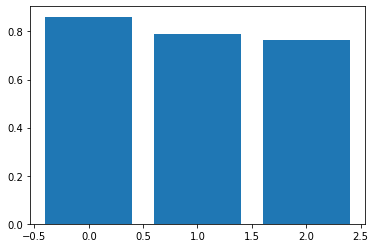

In [320]:
import matplotlib.pyplot as plt
#Showing r2 values
r2_scores = [model.score(X_train,y_train),model.score(X_val,y_val),model.score(X_test,y_test)]
print(r2_scores)
xrange = np.arange(len(r2_scores))
plt.bar(x = xrange, height = r2_scores)
plt.show()

###Do one-hot encoding.
 
 This was done above

###Do feature scaling.

I'm going to do this in the pipeline

### Get and plot your coefficients.


In [321]:
model.coef_[0]

array([ 0.41476729, -0.21043444, -0.60248944, -0.47613278, -0.07389469,
        0.28545671,  0.03967141, -0.33128012, -0.73133273,  1.30878112,
        0.67353809,  0.14626087,  1.19487927,  0.95064949,  0.99723315,
        0.08717249,  0.45146906,  1.24005272, -0.02232874, -0.00338758])

(1, 20)


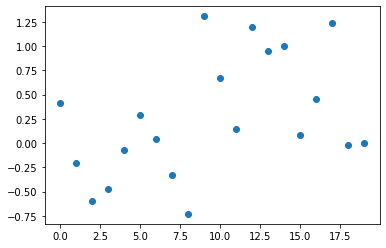

In [322]:
print(model.coef_.shape)
plt.scatter(np.arange(len(model.coef_[0])),model.coef_[0])
plt.show()

### Try scikit-learn pipelines.

In [410]:
#Importing everything that I think I'll need
from sklearn.pipeline import Pipeline
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

In [324]:
final_df.head()

,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,1/18/2016,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,California,1/24/2016,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,Carnitas,1/24/2016,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,Asada,1/24/2016,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,California,1/27/2016,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [325]:
final_df.Chips.value_counts()

x      21
X       3
No      1
Yes     1
Name: Chips, dtype: int64

In [326]:
#Truly awful. I think I'm just going to drop these kinds of columns
final_df.dropna(axis = 1,thresh = int(len(final_df) * (2/3)),inplace=True)

In [327]:
final_df.head()

,Burrito,Date,Cost,Hunger,Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Great
0,California,1/18/2016,6.49,3.0,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,False
1,California,1/24/2016,5.45,3.5,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,False
2,Carnitas,1/24/2016,4.85,1.5,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,False
3,Asada,1/24/2016,5.25,2.0,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,False
4,California,1/27/2016,6.59,4.0,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,True


In [274]:
#Need to rewrite my datetime function to work in the pipeline
from datetime import datetime
def datetoIntDF(df):
  '''
  This function takes a dataframe, and tries to convert datestrings to
  a count from the minimum value to the value of the date

  df is a pandas dataframe

  returns a dataframe
  '''
  for col in df.columns:
    #Try to convert every column to datetime. if it works, convert the column
    try:
      df[col] = (pd.to_datetime(df[col]).dt.date - pd.to_datetime(df[col]).dt.date.min()).apply(lambda x: x.days)
    except:
    #If the conversion fails, go to the next column
      continue
  return df

In [278]:
#Check for proof of correctness
dateDF = final_df.copy()
dateDF = datetoIntDF(dateDF)
dateDF.head()

,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,1708,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,California,1714,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,Carnitas,1714,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,Asada,1714,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,California,1717,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [398]:
#Converting that to a class so it works in the transformer
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
class dateTransformer(BaseEstimator, TransformerMixin):
  date_features = []
  def __init__(self):
    #initializing the columns which can successfully be transformed to days
    print('in init')
    date_features = []

  def fit(self,x,y = None):
    '''
    This function finds the columns which can be saved as days and stores them
    
    x is the list of training features, 
    y is the target but can be discarded

    returns self
    '''
    for col in x.columns:
      try:
        #All integers become dates, so checking if it is the first date
        if(pd.to_datetime(x[col]).dt.date) > datetime(1970):
          self.date_features.append(col)
      except:
        continue
    print(self.date_features)
    return self

  def transform(self, x):
    '''
    This function transforms all date columns into days from minimum date value

    x is a dataframe 

    returns the dataframe with date transformed
    '''
    X_ = x.copy()
    for col in self.date_features:
    #Try to convert every column to datetime. if it works, convert the column
      try:
        X_[col] = (pd.to_datetime(X_[col]).dt.date - pd.to_datetime(X_[col]).dt.date.min()).apply(lambda x: x.days)
      except:
      #If the conversion fails, go to the next column
        continue
    X_.head(5)
    return X_


In [399]:
#Proof of correctness
dateT = dateTransformer()
dateDF = final_df.copy()
dateT.fit(dateDF)
dateDF = dateT.transform(dateDF)
dateDF = datetoIntDF(dateDF)
dateDF.head()

in init
[]


,Burrito,Date,Cost,Hunger,Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Great
0,California,1708,6.49,3.0,NaN,NaN,NaN,0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,False
1,California,1714,5.45,3.5,NaN,NaN,NaN,0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,False
2,Carnitas,1714,4.85,1.5,NaN,NaN,NaN,0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,False
3,Asada,1714,5.25,2.0,NaN,NaN,NaN,0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,False
4,California,1717,6.59,4.0,NaN,NaN,NaN,0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,True


In [411]:
pipe = Pipeline(
                #I need to one hot encode the burrito column
                [('onehot',OneHotEncoder(cols = 'Burrito')),
                 #Note, this time I will just impute with the most frequent
                 ('NaN_Processing',SimpleImputer(strategy='most_frequent')),
                 #PCA
                 ('PCA',PCA(0.9)),
                 #Finally, perform the regression
                 ('regress',LogisticRegression(solver='liblinear')),])

In [412]:
#use train_test_split for random splitting
X = final_df.drop(['Great','Date'],axis=1)
y = final_df.Great
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [413]:
pipe.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('onehot',
                 OneHotEncoder(cols=['Burrito'], drop_invariant=False,
                               handle_missing='value', handle_unknown='value',
                               return_df=True, use_cat_names=False,
                               verbose=0)),
                ('NaN_Processing',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='most_frequent',
                               verbose=0)),
                ('PCA',
                 PCA(copy=True, iterated_power='auto', n_components=0.9,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('regress',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
       

In [414]:
print(pipe.score(X_train,y_train))

0.8898809523809523


In [415]:
print(pipe.score(X_test,y_test))

0.8470588235294118


In [416]:
#original notebook

In [ ]:
#https://colab.research.google.com/drive/19WedLpvx2VnklzWgvP0BeySxD5wREnC6?usp=sharing#scrollTo=Hd1LDF-go7rU